In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('./datasets/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


### Read and Split Data

In [2]:
print("Label:\n", df.loc[0, 'Popularity'])
print("Content:\n",df.loc[0,'Page content'])

Label:
 -1
Content:
 <html><head><div class="article-info"> <span class="byline basic">Clara Moskowitz</span> for <a href="/publishers/space-com/">Space.com</a> <time datetime="Wed, 19 Jun 2013 15:04:30 +0000">2013-06-19 15:04:30 UTC</time> </div></head><body><h1 class="title">NASA's Grand Challenge: Stop Asteroids From Destroying Earth</h1><figure class="article-image"><img class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg" data-micro="1" data-url="http://mashable.com/2013/06/19/nasa-grand-challenge-asteroid/" src="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg"/></figure><article data-channel="world"><section class="article-content"> <p>There may be killer asteroids headed for Earth, and NASA has decided to do something about it. The space agency announced a new "Grand Challenge" on June 18 to find all dangerous space rocks

In [3]:
X = df.loc[:, 'Page content'].to_numpy()
y = df.loc[:,'Popularity'].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape)
print(y_train.shape)
print("Label:\n", y_train[0])
print("Content:\n", X_train[0])

(22114,)
(22114,)
Label:
 -1
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/emily-banks/"><img alt="Default-m" class="author_image" src="http://i.amz.mshcdn.com/raEPzavg65Jzvjy-L4U699QBlmQ=/90x90/default-m.jpg"/></a><span class="author_name">By <a href="/author/emily-banks/">Emily Banks</a></span><time datetime="Fri, 01 Mar 2013 14:53:58 +0000">2013-03-01 14:53:58 UTC</time></span></div></head><body><h1 class="title">Mason Out at Groupon and More News You Need to Know</h1><figure class="article-image"></figure><article data-channel="business"><section class="article-content"> <div class="shift-to-hero"><div class="content-mash-video" data-autoplay="" data-embedurl="http://mashable.com/videos/embed?video=uGc7uydu&amp;player=offsite" data-labels='["Advertising", "Andrew Mason", "CEO", "Facebook", "Groupon", "adidas", "atlas", "college basketball", "first to know", "microsoft", "newsy", "twitter"]' data-playlist="http://content.jwplatform.com/manife

### Feature Engineering

In [4]:
import os

POSITIVE_WORDS = os.path.join(os.getcwd(), 'datasets', 'positive-words.txt')
NEGATIVE_WORDS = os.path.join(os.getcwd(), 'datasets', 'negative-words.txt')
pos_words = []
neg_words = []


for line in open(POSITIVE_WORDS, 'r').readlines()[35:]:
    word = line.rstrip()
    pos_words.append(word)

for line in open(NEGATIVE_WORDS, 'r').readlines()[35:]:
    word = line.rstrip()
    neg_words.append(word)
    
print(len(pos_words))
print(len(neg_words))

2006
4783


In [5]:
import re
from bs4 import BeautifulSoup

def content_first_last(text):
    soup = BeautifulSoup(text, 'html.parser')
    feature_str = ""
    
    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
    if soup.head.find("span") == None:
        feature_str += " "
    else:
        author = re.search(author_re, soup.head.find("span").text).group(1)
        feature_str += author.split(" ")[-1] + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")
    
    # Content first and last sentence
    section = soup.find("section", {"class": "article-content"})
    para_first_last_list = section.find_all('p')
    for para in para_first_last_list:
        para_text = para.get_text()
        if(para_text == None): continue
        sentences = para_text.split('.')
        sentences = [sentence.strip() for sentence in para_text.split('.') if sentence.strip()]
        if len(sentences) >= 2:
            first_sentence = sentences[0].strip() 
            last_sentence = sentences[-1].strip()  
            feature_str += first_sentence + last_sentence
        elif len(sentences) == 1:
            feature_str += sentences[0]
        else: 
            feature_str += ''
        
    # remove numbers
    feature_str = re.sub(r'\d+', '', feature_str)
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = r'(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, feature_str)
    feature_str = re.sub(r, '', feature_str)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    feature_str = re.sub(r'[\W]+', ' ', feature_str.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    
    return feature_str


print(content_first_last(X[70]))

senior employees are a firm s biggest cybersecurity weakness business business small business startups work play the biggest threat to your company s cybersecurity isn t malware phishing scams or even hackers it s youand while the surveys each pointed to slightly different culprits the verdict was clear employees are the weakest link in the security chainthe largest of the three studies a stroz friedberg online survey of more than information workers found that senior management may be the biggest threat to an organization s digital well beingonly percent of rank and file employees were found to have done the samethe stroz friedberg study also found that in senior managers admitted to uploading work files to personal email and cloud based accounts a faux pas that could lead to intellectual property theft and attacks on corporate networkssee also which employees are the biggest security risk in a second study by osterman research security professionals were asked about the biggest cyber

In [6]:
from collections import Counter
from string import punctuation
import re
from bs4 import BeautifulSoup

soup = BeautifulSoup(X[70], 'html.parser')
# print(soup.prettify())

# Title
print("Title: ", soup.find("h1", {"class": "title"}).text)

# Channel
print("Data Channel: ", soup.find("article").get("data-channel"))

# Author
author_re = r'(By\s|^)(.*?)(?=\d{4}-\d{2}-\d{2}|$)'
if soup.head.find("span") == None:
    print("Author: None")
else:
    print("Author: ", re.search(author_re, soup.head.find("span").text).group(1))

# Related Topics
print("Topics: ", soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(","))

# Time
print("Time: ", re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5])

# Weekend
print("Weekend: ", int(soup.time.get("datetime")[:3] in ["Sat", "Sun"]))

# Word Count
text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
total = c_div + c_p
print("Total words: ", len(list(total.elements())))


section = soup.find("section", {"class": "article-content"})

# Video + Image count
img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
media_count = img_count + video_count
print("Media count: ", media_count)

# Appealing count
link_count = len(section.find_all("a"))
strong_count = len(section.find_all("strong"))
appealing_count = link_count + strong_count
print("Link count: ", appealing_count)

Title:  Senior Employees Are a Firm's Biggest Cybersecurity Weakness
Data Channel:  business
Author: None
Topics:  ['Business', ' Small Business', ' Startups', ' Work & Play ']
Time:  18:00
Weekend:  0
Total words:  466
Media count:  0
Link count:  13


In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_neg(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w in neg_words and re.match('[a-zA-Z]+', w)]

def tokenizer_stem_pos(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w in pos_words and re.match('[a-zA-Z]+', w)]

In [8]:
from bs4 import BeautifulSoup


def feature_selection_print(data):
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    print("Title: ", soup.find("h1", {"class": "title"}).text)

    # Channel
    print("Data Channel: ", soup.find("article").get("data-channel"))

    # Author
    author_re = r'(?:By\s)?([a-zA-Z]+(\s[a-zA-Z]+)*)'
    if soup.head.find("span") == None:
        print("Author: None")
    else:
        print("Author: ", re.search(author_re, soup.head.find("span").text).group(1))

    # Related Topics
    print("Topics: ", soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(","))

    # Time
    print("Time: ", re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5])

    # Weekend
    print("Weekend: ", int(soup.time.get("datetime")[:3] in ["Sat", "Sun"]))

    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    print("Total words: ", len(list(total.elements())))


    section = soup.find("section", {"class": "article-content"})

    # Video + Image count
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    print("Media count: ", media_count)

    # Appealing count
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    print("Link count: ", appealing_count)

    # POS & NEG count
    paragraph = section.find_all("p")
    pos_count = 0
    pos_words = []
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            pos_words.append(word)
    print("Positive count: ", pos_count)
    print("Positive words: ", pos_words)

    neg_count = 0
    neg_words = []
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            neg_words.append(word)
    print("Negative count: ", neg_count)
    print("Negative words: ", neg_words)

    # Question & Exclamation count
    q_count = 0
    ex_count = 0
    for tag in paragraph:
        if tag.text.find("?") != -1:
            q_count += tag.text.find("?")
        if tag.text.find("!") != -1:
            ex_count += tag.text.find("!")
    
    print("Question count: ", q_count)
    print("Exclamation count: ", ex_count)


for i in range(200, 205):
    feature_selection_print(X[i])

Title:  California on Track to Enact Nation's First Statewide Plastic Bag Ban
Data Channel:  world
Author:  Katie Sola
Topics:  ['california', ' environmentalism', ' plastic', ' U.S.', ' World ']
Time:  21:55
Weekend:  0
Total words:  437
Media count:  0
Link count:  15
Positive count:  5
Positive words:  ['support', 'conveny', 'support', 'support', 'protect']
Negative count:  5
Negative words:  ['outlaw', 'threaten', 'mistak', 'prohibit', 'struggle']
Question count:  248
Exclamation count:  0
Title:  9 Apps and Resources to Learn American Sign Language
Data Channel:  apps-software
Author:  Yohana Desta
Topics:  ['Apps and Software', ' disabilities', ' education', ' Lifestyle', ' Sign Language', ' Social Good', ' Social Media', ' Work & Play ']
Time:  06:03
Weekend:  0
Total words:  515
Media count:  6
Link count:  18
Positive count:  18
Positive words:  ['easy', 'fre', 'easiest', 'fre', 'lov', 'pretty', 'gre', 'easy', 'fre', 'sup', 'fre', 'fre', 'wil', 'refresh', 'lik', 'fre', 'mast',

In [9]:
def feature_selection(data):
    feature_str = ""
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
    if soup.head.find("span") == None:
        feature_str += " "
    else:
        author = re.search(author_re, soup.head.find("span").text).group(1)
        feature_str += author.split(" ")[-1] + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")

    # Time
    if soup.time.text == None or soup.time.text == "":
        feature_str += "0"
    else:
        hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
        minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
        if hour * 60 + minute < 540:
            feature_str += "morning "
        elif hour * 60 + minute < 720:
            feature_str += "noon "
        elif hour * 60 + minute < 1020:
            feature_str += "afternoon "
        else:
            feature_str += "night "

    # Weekend
    if soup.time.text == None or soup.time.text == "":
        feature_str += "weekday "
    else:
        feature_str += "weekend " if soup.time.get("datetime")[:3] in ["Sat", "Sun"] else "weekday "

    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    if len(list(total.elements())) < 300:
        feature_str += 'wordshort '
    elif len(list(total.elements())) < 600:
        feature_str += 'wordmedium '
    else:
        feature_str += 'wordlong '


    section = soup.find("section", {"class": "article-content"})

    # Video + Image count
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    if media_count < 3:
        feature_str += "nomedia "
    elif media_count < 7:
        feature_str += "fewmedia "
    else:
        feature_str += "manymedia "

    # Appealing count
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    if appealing_count < 5:
        feature_str += "appealshort "
    elif appealing_count < 10:
        feature_str += "appealmedium "
    else:
        feature_str += "appeallong "

    paragraph = section.find_all("p")
    # Statistics count
    stat_count = 0
    for tag in paragraph:
        number = r'\d+'
        matches = re.findall(number, tag.text)
        stat_count += len(matches)
    if stat_count < 5:
        feature_str += "fewstats "
    elif stat_count < 10:
        feature_str += "somestats "
    elif stat_count < 20:
        feature_str += "manystats "
    else:
        feature_str += "lotstats "

    # POS & NEG count
    pos_count = 0
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            feature_str += word + " "


    neg_count = 0
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            feature_str += word + " "
    

    feature_str = re.sub(r'[,-.:\']+', '', feature_str.lower())
    return feature_str

nasas grand challenge stop asteroids from destroying earth world moskowitz asteroid asteroids challenge earth space us world afternoon weekday wordmedium nomedia appeallong improv pref confid win support benefit valu integr win support import accompl innov tim kil dang threats 


In [10]:
def feature_selection_info_word(data):
    feature_str = ""
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
    if soup.head.find("span") == None:
        feature_str += " "
    else:
        author = re.search(author_re, soup.head.find("span").text).group(1)
        feature_str += author.split(" ")[-1] + " "

    section = soup.find("section", {"class": "article-content"})
    paragraph = section.find_all("p")
    pos_count = 0
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            feature_str += word + " "

    neg_count = 0
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            feature_str += word + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")

    feature_str = re.sub(r'[.:\']', '', feature_str.lower())
    return feature_str

print(feature_selection_info_word(X[0]))

nasas grand challenge stop asteroids from destroying earth world moskowitz improv pref confid win support benefit valu integr win support import accompl innov tim kil dang threats asteroid asteroids challenge earth space us world 


In [43]:
from collections import Counter
from string import punctuation
import re
import math
from bs4 import BeautifulSoup

author_score = dict()
author_num = dict()
channel_score = dict()
channel_num = dict()
topic_score = dict()
topic_num = dict()
avg_author = 0
avg_channel = 0
avg_topic = 0

def get_info_score(X_train, y_train):
    global author_score
    global author_num 
    global channel_score 
    global channel_num 
    global topic_score 
    global topic_num 
    global avg_author 
    global avg_channel 
    global avg_topic 

    for html, y in zip(X_train, y_train):
        soup = BeautifulSoup(html, 'html.parser')

        # Author
        author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
        if soup.head.find("span") == None:
            continue
        else:
            author = re.search(author_re, soup.head.find("span").text).group(1)
            if author in author_score:
                author_score[author] += 1 if int(y) == 1 else 0
                author_num[author] += 1
            else : 
                author_score[author] = 0
                author_score[author] += 1 if int(y) == 1 else 0
                author_num[author] = 1

        # Channel
        channel = soup.find("article").get("data-channel")
        if channel in channel_score:
            channel_score[channel] += 1 if int(y)==1 else  0
            channel_num[channel] += 1
        else : 
            channel_score[channel] = 0
            channel_score[channel] += 1 if int(y)==1 else  0
            channel_num[channel] = 1
        
        # Topics
        topics = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
        for topic in topics:
            if topic in topic_score:
                topic_score[topic] += 1 if int(y)==1 else  0
                topic_num[topic] += 1
            else : 
                topic_score[topic] = 0
                topic_score[topic] += 1 if int(y)==1 else  0
                topic_num[topic] = 1

    total_channel = 0
    total_topic = 0
    total_author = 0
    for html in X_train:
        for c, s in channel_score.items():
            avg_channel += s
            total_channel += channel_num[c]
        avg_channel = avg_channel / total_channel

        for c, s in topic_score.items():
            avg_topic += s
            total_topic += topic_num[c]
        avg_topic = avg_topic / total_topic

        for c, s in author_score.items():
            avg_author += s
            total_author += author_num[c]
        avg_author = avg_author / total_author
        

# get_info_score(X_train, y_train) # init author_score


def feature_selection_info_num(data):
    X = []
    for html in data:
        soup = BeautifulSoup(html, 'html.parser')
        feature_list = []
        
        # # Author score
        # author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
        # if soup.head.find("span") == None:
        #     feature_list.append(avg_author)
        # else:
        #     author = re.search(author_re, soup.head.find("span").text).group(1)
        #     if(author in author_score):
        #         feature_list.append(author_score[author] / author_num[author])
        #     else:
        #         feature_list.append(avg_author)  

        # Channel score
        # channel = soup.find("article").get("data-channel")
        # if channel in channel_score:
        #     feature_list.append(channel_score[channel] / channel_num[channel])
        # else:
        #     feature_list.append(avg_channel)

        # # Topic score
        # topics = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
        # total_score = 0
        # order = 0 
        # order_denominator = 0
        # for i in range(len(topics)):
        #     order_denominator += math.exp(-0.5 * i)
        # for topic in topics:
        #     order_coef = math.exp(-0.5*order)/order_denominator
        #     if topic in topic_score:
        #         total_score += (topic_score[topic] / topic_num[topic]) * order_coef
        #     else:
        #         total_score += avg_topic * order_coef
        #     order+=1
        # feature_list.append(total_score)
              
        # word count of title
        feature_list.append(len(soup.find("h1", {"class": "title"}).text))
        
        # average word length and unique word rate
        words = re.findall(r'\w+', soup.get_text().lower())
        if words:
            total_words = len(words)
            unique_words = set(words)
            unique_word_count = len(unique_words)
            total_length = sum(len(word) for word in words)
            unique_rate = unique_word_count / total_words
            average_length = total_length / len(words)
            feature_list.append(unique_rate)
            feature_list.append(average_length)
        
        # Time
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
            feature_list.append(0)
        else:
            month = int(re.search(r'(\d+-\d+-\d+)', soup.time.text).group(1).split("-")[1])
            feature_list.append(month)
            hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
            minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
            feature_list.append(hour * 60 + minute)

        # Weekend
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
        else:
            feature_list.append(1 if soup.time.get("datetime")[:3] in ["Sat", "Sun"] else 0)

        # Word Count
        text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
        c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
        text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
        c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
        total = c_div + c_p
        feature_list.append(len(list(total.elements())))


        section = soup.find("section", {"class": "article-content"})

        # Video + Image count
        img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
        video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
        media_count = img_count + video_count
        feature_list.append(media_count)

        # Appealing count
        link_count = len(section.find_all("a"))
        strong_count = len(section.find_all("strong"))
        appealing_count = link_count + strong_count
        feature_list.append(appealing_count)
        
        # See also count
        feature_list.append(len(soup.find_all("div", {"class": "see-also"})))

        # POS & NEG count
        paragraph = section.find_all("p")
        pos_count = 0
        for tag in paragraph:
            pos_count += len(tokenizer_stem_pos(tag.text))
        feature_list.append(pos_count)

        neg_count = 0
        for tag in paragraph:
            neg_count += len(tokenizer_stem_neg(tag.text))
        feature_list.append(neg_count)

        # Question & Exclamation count
        # q_count = 0
        # ex_count = 0
        # for tag in paragraph:
        #     if tag.text.find("?") != -1:
        #         q_count += tag.text.find("?")
        #     if tag.text.find("!") != -1:
        #         ex_count += tag.text.find("!")
        
        # feature_list.append(q_count)
        # feature_list.append(ex_count)

        X.append(feature_list)
        
    return np.array(X)

print(feature_selection_info_num(X[:10]))

[[6.00000000e+01 4.89731438e-01 4.81042654e+00 6.00000000e+00
  9.04000000e+02 0.00000000e+00 5.43000000e+02 0.00000000e+00
  1.80000000e+01 0.00000000e+00 1.40000000e+01 3.00000000e+00]
 [7.40000000e+01 4.74719101e-01 4.65449438e+00 3.00000000e+00
  1.06000000e+03 0.00000000e+00 3.21000000e+02 0.00000000e+00
  9.00000000e+00 1.00000000e+00 5.00000000e+00 3.00000000e+00]
 [6.80000000e+01 4.98765432e-01 4.40987654e+00 5.00000000e+00
  1.15500000e+03 0.00000000e+00 2.55800000e+03 5.00000000e+01
  4.00000000e+00 1.00000000e+00 3.30000000e+01 2.10000000e+01]
 [4.30000000e+01 7.26351351e-01 4.65540541e+00 1.00000000e+01
  1.46000000e+02 0.00000000e+00 4.86000000e+02 4.10000000e+01
  8.00000000e+00 1.00000000e+00 2.00000000e+00 5.00000000e+00]
 [6.10000000e+01 4.80314961e-01 4.56167979e+00 4.00000000e+00
  2.11000000e+02 0.00000000e+00 1.59400000e+03 1.01000000e+02
  1.00000000e+01 1.00000000e+00 8.00000000e+00 1.00000000e+00]
 [5.00000000e+01 4.80791618e-01 4.77415600e+00 1.10000000e+01
  1

### Stemming

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.lancaster import LancasterStemmer

# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = EnglishStemmer()
    return [porter.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

for i in range(10):
    print(tokenizer_stem_nostop(feature_selection(X[i])))


['nasa', 'grand', 'challeng', 'stop', 'asteroid', 'destroy', 'earth', 'world', 'moskowitz', 'asteroid', 'asteroid', 'challeng', 'earth', 'space', 'us', 'world', 'afternoon', 'weekday', 'wordmedium', 'nomedia', 'appeallong', 'improv', 'pref', 'confid', 'win', 'support', 'benefit', 'valu', 'integr', 'win', 'support', 'import', 'accompl', 'innov', 'tim', 'kil', 'dang', 'threat']
['googl', 'new', 'open', 'sourc', 'patent', 'pledg', 'wont', 'sue', 'unless', 'attack', 'first', 'tech', 'warren', 'app', 'softwar', 'googl', 'open', 'sourc', 'opn', 'pledg', 'patent', 'lawsuit', 'theater', 'softwar', 'patent', 'tech', 'us', 'night', 'weekday', 'wordmedium', 'nomedia', 'appealmedium', 'prom', 'avail', 'avail', 'wel', 'good', 'sue', 'sue', 'limit']
['ballin', 'nfl', 'draft', 'pick', 'get', 'choos', 'walk-out', 'music', 'entertain', 'laird', 'entertain', 'nfl', 'nfl', 'draft', 'sport', 'televis', 'night', 'weekday', 'wordlong', 'manymedia', 'appealshort', 'top', 'perfect', 'improv', 'appropri', 'her

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

for i in range(10):
    print(tokenizer_stem_nostop(feature_selection(X[i])))

['nasa', 'grand', 'challeng', 'stop', 'asteroid', 'destroy', 'ear', 'world', 'moskowitz', 'asteroid', 'asteroid', 'challeng', 'ear', 'spac', 'us', 'world', 'afternoon', 'weekday', 'wordmed', 'nomed', 'appeallong', 'improv', 'pref', 'confid', 'win', 'support', 'benefit', 'valu', 'integr', 'win', 'support', 'import', 'accompl', 'innov', 'tim', 'kil', 'dang', 'threats']
['googl', 'new', 'op', 'sourc', 'pat', 'pledg', 'wont', 'sue', 'unless', 'attack', 'first', 'tech', 'war', 'ap', 'softw', 'googl', 'op', 'sourc', 'opn', 'pledg', 'pat', 'lawsuit', 'the', 'softw', 'pat', 'tech', 'us', 'night', 'weekday', 'wordmed', 'nomed', 'appealmed', 'prom', 'avail', 'avail', 'wel', 'good', 'sue', 'sue', 'limit']
['ballin', 'nfl', 'draft', 'pick', 'get', 'choos', 'walk-out', 'mus', 'entertain', 'laird', 'entertain', 'nfl', 'nfl', 'draft', 'sport', 'televid', 'night', 'weekday', 'wordlong', 'manymed', 'appealshort', 'top', 'perfect', 'improv', 'appropry', 'hero', 'right', 'fav', 'bet', 'hug', 'benefit', '

### TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=content_first_last,
                        tokenizer=tokenizer_stem_nostop,
                        max_features=1000)

tfidf.fit(X_train)

top = 100
# get idf score of vocabularies
idf = tfidf.idf_
# print('[vocabularies with smallest idf scores]')
# sorted_idx = idf.argsort()

# for i in range(top):
#     # When sklearn version <= 0.24.x, should use get_feature_names()
#     # When sklearn version >= 1.0.x, should use get_feature_names_out()
#     print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[-(i+1)]], idf[sorted_idx[-(i+1)]]))


doc_tfidf = tfidf.transform(X_train).toarray()
tfidf_sum = np.sum(doc_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))

c:\Users\user\anaconda3\envs\DeepLearning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



[vocabularies with highest tf-idf scores]
video: 936.9509498571376
us: 863.6564949281948
new: 793.5961139492256
ap: 722.075907306366
also: 683.1967662881051
gam: 608.3270210004524
world: 604.6719478389231
on: 574.6213342702274
lik: 538.3092741968458
watercool: 533.355509474707
tim: 523.1407742214898
com: 515.3713785797258
said: 510.8396831010343
year: 508.6617214704774
googl: 505.3688963963648
company: 498.0206617171502
busy: 495.28238768252584
ev: 480.68676987556825
tech: 472.73977061151464
mak: 466.9482644572476
facebook: 459.2232023496021
soc: 459.023539250993
med: 457.8890423810361
im: 448.6881561834264
get: 446.06335536554894
twit: 441.2058666287875
appl: 440.3454693942127
courtesy: 439.9559908908447
first: 435.25812557644184
show: 433.00753433989274
entertain: 430.41979156177916
work: 427.5007041769656
peopl: 403.57610577768395
off: 403.5073179626609
ad: 403.3332990390443
mus: 398.36003614248443
act: 395.7544526772645
say: 393.3986321180629
tak: 389.12095940907756
look: 382.6190

In [15]:
from sklearn.preprocessing import StandardScaler

doc_tfidf = tfidf.transform(X[:2])
print(doc_tfidf.shape)
print(doc_tfidf[0])

scaler = StandardScaler(with_mean=False)
scaler.fit(doc_tfidf)
print(scaler.transform(doc_tfidf))


(2, 1000)
  (0, 985)	0.08199159559013626
  (0, 983)	0.045982313474134125
  (0, 946)	0.08387682524309581
  (0, 918)	0.06837029770753764
  (0, 917)	0.057742131831501016
  (0, 898)	0.08525087509317383
  (0, 888)	0.07503962851516922
  (0, 877)	0.056759570375497635
  (0, 831)	0.1503048978557666
  (0, 810)	0.22169869290337502
  (0, 802)	0.06578396827168037
  (0, 761)	0.07964458689782535
  (0, 755)	0.09273370907901497
  (0, 754)	0.06868778620684579
  (0, 753)	0.04509774482379667
  (0, 735)	0.046568059938384115
  (0, 727)	0.09324518380497147
  (0, 712)	0.1768257521583118
  (0, 680)	0.08747887225057968
  (0, 679)	0.10748770699796445
  (0, 672)	0.07354989362272621
  (0, 638)	0.12484602042164221
  (0, 616)	0.05704429459507586
  (0, 606)	0.07693084280892959
  (0, 605)	0.06014464177030558
  :	:
  (0, 390)	0.07053065539238526
  (0, 320)	0.05994061651876453
  (0, 315)	0.08512557648395544
  (0, 291)	0.08700695722325799
  (0, 278)	0.04021995652419137
  (0, 248)	0.1741666564983195
  (0, 246)	0.089001572

### Hashing Vectorizer

In [16]:
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import HashingVectorizer

# hash words to 2048 buckets
hashvec = HashingVectorizer(n_features=2**20,
                            preprocessor=feature_selection,
                            tokenizer=tokenizer_stem_nostop)

### Model Training

In [17]:
import math

def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[0]  # number of training examples
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]
    
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


### MultiVec + MultiClassifier

In [34]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

y_train_label = LabelEncoder().fit_transform(y_train)
y_valid_label = LabelEncoder().fit_transform(y_valid)

In [ ]:
# Info-word model
# info_word_model = XGBClassifier(max_depth=10, early_stopping_rounds=10)
info_word_model = SGDClassifier(loss='log_loss', alpha=0.01, max_iter=250, tol=1e-3)
# info_word_model = RandomForestClassifier(n_estimators=101, max_depth=7, min_samples_leaf=31, n_jobs=-1)

print('Begin Info word Training...')
hashvec = HashingVectorizer(n_features=2**20, preprocessor=feature_selection, tokenizer=tokenizer_stem_nostop)
x_train_info_word = hashvec.transform(X_train)
info_word_model.fit(x_train_info_word, y_train_label)

print('Begin Evaluation...')
y_pred_info_word_train = info_word_model.predict_proba(x_train_info_word)[:,1]
y_pred_info_word_valid = info_word_model.predict_proba(hashvec.transform(X_valid))[:,1]
print("Info word train:", roc_auc_score(y_train_label, y_pred_info_word_train))
print("Info word valid:", roc_auc_score(y_valid_label, y_pred_info_word_valid))

In [42]:
# Info-num model
# info_num_model = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=0)
# info_num_model = XGBClassifier(max_depth=10, early_stopping_rounds=10)
# info_num_model = RandomForestClassifier(n_estimators=500, max_depth=9, min_samples_leaf=8, n_jobs=-1)
info_num_model = LGBMClassifier(
    n_estimators=500,
    max_depth=9,
    num_leaves=127, 
    reg_lambda=0.01, 
    early_stopping_rounds=20,
    n_jobs=-1)

print("Begin Info num Training...")
x_train_info_num = feature_selection_info_num(X_train)
eval_set = [(feature_selection_info_num(X_valid), LabelEncoder().fit_transform(y_valid))]
info_num_model.fit(x_train_info_num, y_train_label, eval_set=eval_set)
# info_num_model.fit(x_train_info_num, y_train_label)

print('Begin Evaluation...')
y_pred_info_num_train = info_num_model.predict_proba(x_train_info_num)[:,1]
y_pred_info_num_valid = info_num_model.predict_proba(feature_selection_info_num(X_valid))[:,1]
print("Info num train:", roc_auc_score(y_train_label, y_pred_info_num_train))
print("Info num valid:", roc_auc_score(y_valid_label, y_pred_info_num_valid))

Begin Info num Training...
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] Number of positive: 10896, number of negative: 11218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1671
[LightGBM] [Info] Number of data points in the train set: 22114, number of used features: 13
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492720 -> initscore=-0.029124
[LightGBM] [Info] Start training from score -0.029124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] 

In [39]:
# Content model
# content_model = RandomForestClassifier(n_estimators=500, max_depth=12, min_samples_leaf=8, n_jobs=-1)
# content_model = XGBClassifier(
#     n_estimators=500,
#     max_depth=9, 
#     early_stopping_rounds=20, 
#     objective='binary:logistic'
# , 
#     reg_lambda=0.1, 
#     min_child_weight=3,
#     n_jobs=-1)
content_model = LGBMClassifier(
    n_estimators=500,
    max_depth=9,
    num_leaves=127, 
    reg_lambda=0.01, 
    early_stopping_rounds=20,
    n_jobs=-1)
# content_model = SGDClassifier(loss='log_loss', max_iter=300, tol=1e-3, n_jobs=-1)

print('Begin Content Training...')
hashvec_content = HashingVectorizer(n_features=2**20, preprocessor=content_first_last, tokenizer=tokenizer_stem_nostop)
eval_set = [(tfidf.transform(X_valid), LabelEncoder().fit_transform(y_valid))]
x_train_content = tfidf.transform(X_train)
content_model.fit(x_train_content, y_train_label, eval_metric="error", eval_set=eval_set)
# content_model.fit(x_train_content, y_train_label)

print('Begin Evaluation...')
y_pred_content_train = content_model.predict_proba(x_train_content)[:,1]
y_pred_content_valid = content_model.predict_proba(tfidf.transform(X_valid))[:,1]
print("Content train:", roc_auc_score(y_train_label, y_pred_content_train))
print("Content valid:", roc_auc_score(y_valid_label, y_pred_content_valid))

Begin Content Training...
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] Number of positive: 10896, number of negative: 11218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 248577
[LightGBM] [Info] Number of data points in the train set: 22114, number of used features: 1000
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492720 -> initscore=-0.029124
[LightGBM] [Info] Start training from score -0.029124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGB

In [132]:
train_score = []
valid_score = []
coef_ = np.linspace(0,1,21)

for i in coef_:
    j_range = np.linspace(0, 1-i, 21)
    for j in j_range:
        k = 1 - i - j
        print(f'Proportion (Model 1): {i}, Proportion (Model 2): {j}, Proportion (Model 3): {k}')
        train_score = roc_auc_score(y_train, (y_pred_info_word_train*i) + (y_pred_info_num_train*j) + (y_pred_content_train*k))
        valid_score = roc_auc_score(y_valid, (y_pred_info_word_valid*i) + (y_pred_info_num_valid*j) + (y_pred_content_valid*k))
        print(f'Combine train score: {train_score}')
        print(f'Combine valid score: {valid_score}')

Proportion (Model 1): 0.0, Proportion (Model 2): 0.0, Proportion (Model 3): 1.0
Combine train score: 0.6975811921146762
Combine valid score: 0.5447474157406883
Proportion (Model 1): 0.0, Proportion (Model 2): 0.05, Proportion (Model 3): 0.95
Combine train score: 0.7099601707673502
Combine valid score: 0.5530511873878514
Proportion (Model 1): 0.0, Proportion (Model 2): 0.1, Proportion (Model 3): 0.9
Combine train score: 0.7129191421367852
Combine valid score: 0.5551532208759158
Proportion (Model 1): 0.0, Proportion (Model 2): 0.15000000000000002, Proportion (Model 3): 0.85
Combine train score: 0.7153199996321729
Combine valid score: 0.5575178940458917
Proportion (Model 1): 0.0, Proportion (Model 2): 0.2, Proportion (Model 3): 0.8
Combine train score: 0.7169042252408482
Combine valid score: 0.5598472345232337
Proportion (Model 1): 0.0, Proportion (Model 2): 0.25, Proportion (Model 3): 0.75
Combine train score: 0.7183539272354138
Combine valid score: 0.5616345453232078
Proportion (Model 1

In [282]:
hashvec_word = HashingVectorizer(n_features=2**20, preprocessor=feature_selection, tokenizer=tokenizer_stem_nostop)
hashvec_para = HashingVectorizer(n_features=2**20, preprocessor=content_first_last, tokenizer=tokenizer_stem_nostop)
word_vec_train = hashvec_word.transform(X_train)
num_vec_train = feature_selection_info_num(X_train)
para_vec_train = hashvec_para.transform(X_train)

word_vec_valid = hashvec_word.transform(X_valid)
num_vec_valid = feature_selection_info_num(X_valid)
para_vec_valid = hashvec_para.transform(X_valid)
    

In [309]:
# Info-word model
# info_word_model = XGBClassifier(
#     n_estimators=500,
#     max_depth=9, 
#     early_stopping_rounds=20, 
#     objective='binary:logistic', 
#     reg_lambda=0.1, 
#     min_child_weight=3,
#     n_jobs=-1)
info_word_model = SGDClassifier(loss='log_loss', alpha=0.0003, max_iter=1000, tol=1e-3)
# info_word_model = RandomForestClassifier(n_estimators=600, max_depth=5, min_samples_leaf=8, n_jobs=-1)
# info_word_model = LGBMClassifier(
#     n_estimators=600,
#     max_depth=7,
#     num_leaves=100,
#     min_child_samples=8,
#     reg_lambda=1.2, 
#     early_stopping_rounds=20,
#     n_jobs=-1,
#     verbosity=-1)

print('Begin Info word Training...')
eval_set = [(word_vec_valid, y_valid_label)]
# info_word_model.fit(word_vec_train, y_train_label, eval_set=eval_set)
info_word_model.fit(word_vec_train, y_train_label)

print('Begin Evaluation...')
y_pred_info_word_train = info_word_model.predict_proba(word_vec_train)[:,1]
y_pred_info_word_valid = info_word_model.predict_proba(word_vec_valid)[:,1]
print("Info word train:", roc_auc_score(y_train_label, y_pred_info_word_train))
print("Info word valid:", roc_auc_score(y_valid_label, y_pred_info_word_valid))

Begin Info word Training...
Begin Evaluation...
Info word train: 0.6470899669845689
Info word valid: 0.5734594160840698


In [310]:
# Info-num model
# info_num_model = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=0)
# info_num_model = XGBClassifier(max_depth=10, early_stopping_rounds=10)
# info_num_model = RandomForestClassifier(n_estimators=600, max_depth=7, min_samples_leaf=8, n_jobs=-1)
info_num_model = LGBMClassifier(
    n_estimators=600,
    max_depth=7,
    num_leaves=100,
    min_child_samples=8,
    reg_lambda=1.2, 
    early_stopping_rounds=20,
    n_jobs=-1,
    verbosity=-1)

print("Begin Info num Training...")
eval_set = [(num_vec_valid, y_valid_label)]
info_num_model.fit(num_vec_train, y_train_label, eval_set=eval_set)
# info_num_model.fit(num_vec_train, y_train_label)

print('Begin Evaluation...')
y_pred_info_num_train = info_num_model.predict_proba(num_vec_train)[:,1]
y_pred_info_num_valid = info_num_model.predict_proba(num_vec_valid)[:,1]
print("Info num train:", roc_auc_score(y_train_label, y_pred_info_num_train))
print("Info num valid:", roc_auc_score(y_valid_label, y_pred_info_num_valid))

Begin Info num Training...
Begin Evaluation...
Info num train: 0.6861954244659765
Info num valid: 0.5832932241841027


In [311]:
# Content model
# content_model = RandomForestClassifier(n_estimators=600, max_depth=5, min_samples_leaf=16, n_jobs=-1, max_features=0.15)
# content_model = XGBClassifier(
#     n_estimators=600,
#     max_depth=5, 
#     early_stopping_rounds=20, 
#     objective='binary:logistic', 
#     reg_lambda=0.1, 
#     min_child_weight=3,
#     n_jobs=-1)
content_model = LGBMClassifier(
    n_estimators=600,
    max_depth=5,
    num_leaves=30,
    min_child_samples=64,
    # learning_rate = 0.01, 
    reg_lambda=2, 
    early_stopping_rounds=20,
    n_jobs=-1,
    verbosity=-1)
# content_model = SGDClassifier(loss='log_loss', alpha=0.0003, max_iter=1000, tol=1e-3)

print('Begin Content Training...')
eval_set = [(para_vec_valid, y_valid_label)]
content_model.fit(para_vec_train, y_train_label, eval_set=eval_set)
# content_model.fit(para_vec_train, y_train_label)

print('Begin Evaluation...')
y_pred_content_train = content_model.predict_proba(para_vec_train)[:,1]
y_pred_content_valid = content_model.predict_proba(para_vec_valid)[:,1]
print("Content train:", roc_auc_score(y_train_label, y_pred_content_train))
print("Content valid:", roc_auc_score(y_valid_label, y_pred_content_valid))

Begin Content Training...
Begin Evaluation...
Content train: 0.690066547423914
Content valid: 0.5637874186301175


In [312]:
train_score = []
valid_score = []
coef_ = np.linspace(0,1,21)

for i in coef_:
    j_range = np.linspace(0, 1-i, 21)
    for j in j_range:
        k = 1 - i - j
        print(f'Proportion (Model 1): {i}, Proportion (Model 2): {j}, Proportion (Model 3): {k}')
        train_score = roc_auc_score(y_train, (y_pred_info_word_train*i) + (y_pred_info_num_train*j) + (y_pred_content_train*k))
        valid_score = roc_auc_score(y_valid, (y_pred_info_word_valid*i) + (y_pred_info_num_valid*j) + (y_pred_content_valid*k))
        print(f'Combine train score: {train_score}')
        print(f'Combine valid score: {valid_score}')

Proportion (Model 1): 0.0, Proportion (Model 2): 0.0, Proportion (Model 3): 1.0
Combine train score: 0.690066547423914
Combine valid score: 0.5637874186301175
Proportion (Model 1): 0.0, Proportion (Model 2): 0.05, Proportion (Model 3): 0.95
Combine train score: 0.7054650547525754
Combine valid score: 0.5720556612919099
Proportion (Model 1): 0.0, Proportion (Model 2): 0.1, Proportion (Model 3): 0.9
Combine train score: 0.7178606658024692
Combine valid score: 0.5794140216874685
Proportion (Model 1): 0.0, Proportion (Model 2): 0.15000000000000002, Proportion (Model 3): 0.85
Combine train score: 0.7272434894923173
Combine valid score: 0.5854413864653278
Proportion (Model 1): 0.0, Proportion (Model 2): 0.2, Proportion (Model 3): 0.8
Combine train score: 0.7339685330098026
Combine valid score: 0.5898732838780325
Proportion (Model 1): 0.0, Proportion (Model 2): 0.25, Proportion (Model 3): 0.75
Combine train score: 0.7384506572652143
Combine valid score: 0.5929788966987226
Proportion (Model 1)

In [186]:
df = pd.read_csv('./datasets/test.csv')
print("Content:\n",df.loc[0])

Id = df.loc[:, 'Id'].to_numpy()
X_test = df.loc[:, 'Page content'].to_numpy()
print(X_test.shape)
print("\nId:\n", Id[0])
print("Content:\n", X_test[0])

y_pred = info_num_model.predict_proba(feature_selection_info_num(X_test))[:,1]
print(y_pred.shape)
print(y_pred[0])

Content:
 Id                                                          27643
Page content    <html><head><div class="article-info"><span cl...
Name: 0, dtype: object
(11847,)

Id:
 27643
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/sam-laird/"><img alt="2016%2f09%2f15%2f63%2fhttpsd2mhye01h4nj2n.cloudfront.netmediazgkymde1lza2.9814b" class="author_image" src="http://i.amz.mshcdn.com/-qaMPB8aiQeIaoBhqlU0OLjA07A=/90x90/2016%2F09%2F15%2F63%2Fhttpsd2mhye01h4nj2n.cloudfront.netmediaZgkyMDE1LzA2.9814b.jpg"/></a><span class="author_name">By <a href="/author/sam-laird/">Sam Laird</a></span><time datetime="Mon, 09 Sep 2013 19:47:02 +0000">2013-09-09 19:47:02 UTC</time></span></div></head><body><h1 class="title">Soccer Star Gets Twitter Death Threats After Tackling One Direction Member</h1><figure class="article-image"></figure><article data-channel="entertainment"><section class="article-content"> <div class="shift-to-hero"> <p><iframe allowfullscreen="" 

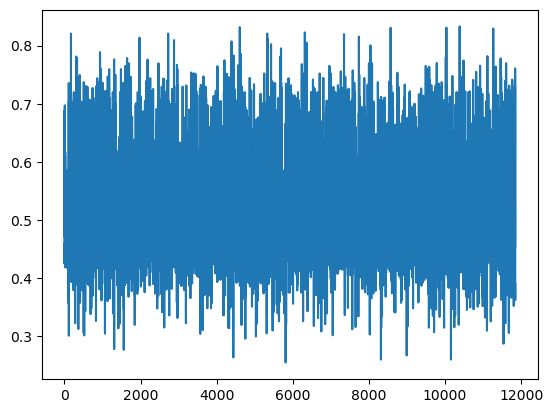

0.25506430579904593 0.8327440560507813


In [187]:
import matplotlib.pyplot as plt

plt.plot(y_pred)
plt.show()
print(np.min(y_pred), np.max(y_pred))

In [80]:
word_model = SGDClassifier(loss='log_loss', alpha=0.01, max_iter=300, tol=1e-3, n_jobs=-1)
num_model = LGBMClassifier(
    n_estimators=500,
    max_depth=9,
    num_leaves=127, 
    reg_lambda=0.01, 
    n_jobs=-1)
para_model = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_leaf=16, max_features='sqrt',n_jobs=-1)
voting = VotingClassifier(estimators=[('sgdc', word_model), ('lgbm', num_model), ('rfc', para_model)], voting='soft')

print('Begin Voting Training...')
# x_train_all = feature_selection_all(X_train, True)
# voting = voting.fit(final_input_train, y_train_label)
para_model.fit(final_input_train, y_train_label)

print('Begin Evaluation...')                                        
y_pred_train = para_model.predict_proba(final_input_train)[:,1]
y_pred_valid = para_model.predict_proba(final_input_valid)[:,1]

train_score = roc_auc_score(y_train_label, y_pred_train)
valid_score = roc_auc_score(y_valid_label, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

Begin Voting Training...
Begin Evaluation...
Stats train score: 0.7221075394026644
Stats valid score: 0.5446763577699469


In [224]:
import pickle
info_word_file = "models/info_word_model.pkl"
info_num_file = "models/info_num_model.pkl"
content_file = "models/content_model.pkl"
# with open(info_word_file, 'wb') as file:
#     pickle.dump(info_word_model, file)
    
# with open(info_num_file, 'wb') as file:
#     pickle.dump(info_num_model, file)

with open(content_file, 'wb') as file:
    pickle.dump(content_model, file)

### Prediction

In [111]:
df = pd.read_csv('./datasets/test.csv')
print("Content:\n",df.loc[0])

Id = df.loc[:, 'Id'].to_numpy()
X_test = df.loc[:, 'Page content'].to_numpy()
print(X_test.shape)
print("\nId:\n", Id[0])
print("Content:\n", X_test[0])

Content:
 Id                                                          27643
Page content    <html><head><div class="article-info"><span cl...
Name: 0, dtype: object
(11847,)

Id:
 27643
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/sam-laird/"><img alt="2016%2f09%2f15%2f63%2fhttpsd2mhye01h4nj2n.cloudfront.netmediazgkymde1lza2.9814b" class="author_image" src="http://i.amz.mshcdn.com/-qaMPB8aiQeIaoBhqlU0OLjA07A=/90x90/2016%2F09%2F15%2F63%2Fhttpsd2mhye01h4nj2n.cloudfront.netmediaZgkyMDE1LzA2.9814b.jpg"/></a><span class="author_name">By <a href="/author/sam-laird/">Sam Laird</a></span><time datetime="Mon, 09 Sep 2013 19:47:02 +0000">2013-09-09 19:47:02 UTC</time></span></div></head><body><h1 class="title">Soccer Star Gets Twitter Death Threats After Tackling One Direction Member</h1><figure class="article-image"></figure><article data-channel="entertainment"><section class="article-content"> <div class="shift-to-hero"> <p><iframe allowfullscreen="" 

In [ ]:
word_vec = hashvec_word.transform(X_test)
num_vec = feature_selection_info_num(X_test)
para_vec = hashvec_para.transform(X_test)

In [120]:
with open('models/info_word_model.pkl', 'rb') as file:
    info_word_model = pickle.load(file)
with open('models/info_num_model.pkl', 'rb') as file:
    info_num_model = pickle.load(file)
with open('models/content_model.pkl', 'rb') as file:
    content_model = pickle.load(file)
    
i = 0.4
j = 0.27
k = 0.33

valid_score = roc_auc_score(y_valid, (y_pred_info_word_valid*i) + (y_pred_info_num_valid*j) + (y_pred_content_valid*k))
print(valid_score)

y_pred_info_word = info_word_model.predict_proba(hashvec.transform(X_test))[:,1]
y_pred_info_num = info_num_model.predict_proba(feature_selection_info_num(X_test))[:,1]
y_pred_content = content_model.predict_proba(tfidf.transform(X_test))[:,1]

y_pred_final = (y_pred_info_word*i) + (y_pred_info_num*j) + (y_pred_content*k)
print(y_pred_final.shape)
print(y_pred_final[0])

0.5766655307860293
(11847,)
0.48883575764567433


In [188]:
output_data = {'Id': Id, 'Popularity': y_pred}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)

output_dataframe.to_csv("./datasets/y_pred.csv", index=None)

          Id  Popularity
0      27643    0.459056
1      27644    0.427184
2      27645    0.424800
3      27646    0.540323
4      27647    0.427273
...      ...         ...
11842  39485    0.760568
11843  39486    0.523603
11844  39487    0.467632
11845  39488    0.362275
11846  39489    0.390382

[11847 rows x 2 columns]


In [121]:
output_data = {'Id': Id, 'Popularity': y_pred_final}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)

output_dataframe.to_csv("./datasets/y_pred.csv", index=None)

          Id  Popularity
0      27643    0.488836
1      27644    0.524053
2      27645    0.470289
3      27646    0.482285
4      27647    0.498659
...      ...         ...
11842  39485    0.566068
11843  39486    0.512062
11844  39487    0.479563
11845  39488    0.481064
11846  39489    0.497516

[11847 rows x 2 columns]
